In [56]:
import pandas as pd
import numpy as np

### Data

In [57]:
data1 = pd.read_csv('../../Data/Jeju/201901-202003.csv')
data1 = data1.fillna('')
# data2 = pd.read_csv('../../Data/Jeju/202004.csv')
# data2 = data2.fillna('')

In [58]:
# data = pd.concat([data1, data2])
data = data1

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24697792 entries, 0 to 24697791
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.2+ GB


#### 결측 처리

In [60]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 18 사업체총조사

In [61]:
all_jobs_df = pd.read_csv('data/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [62]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [63]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [64]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 거래횟수와 이용고객과의 관계 (2019)

In [65]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [66]:
trade_num_2019 = cust_differ(data)

#### 2020 (copy) -> 2019

In [67]:
trade_num_2019

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,NaN
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,NaN
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,NaN
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,NaN,1,NaN
...,...,...,...,...,...,...
7735,대전,여행사업,201908.0,NaN,8,NaN
7736,대전,여행사업,201909.0,NaN,9,NaN
7737,대전,여행사업,201910.0,NaN,0,NaN
7738,대전,여행사업,201911.0,NaN,1,NaN


In [68]:
trade_num_2020 = trade_num_2019.copy()
trade_num_2020['REG_YYMM'] += 100

In [69]:
trade_num_2020

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,202001.0,80.0,1,-32.0
1,강원,골프장 운영업,202001.0,14890.0,1,NaN
2,강원,과실 및 채소 소매업,202001.0,7484.0,1,NaN
3,강원,관광 민예품 및 선물용품 소매업,202001.0,195.0,1,NaN
4,강원,그외 기타 분류안된 오락관련 서비스업,202001.0,NaN,1,NaN
...,...,...,...,...,...,...
7735,대전,여행사업,202008.0,NaN,8,NaN
7736,대전,여행사업,202009.0,NaN,9,NaN
7737,대전,여행사업,202010.0,NaN,0,NaN
7738,대전,여행사업,202011.0,NaN,1,NaN


In [70]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [71]:
trade_num.loyal = trade_num.loyal.fillna(-999)
trade_num.refund = trade_num.refund.fillna(999)

In [72]:
trade_num

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,999.0
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,999.0
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,999.0
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,-999.0,1,999.0
...,...,...,...,...,...,...
7735,대전,여행사업,202008.0,-999.0,8,999.0
7736,대전,여행사업,202009.0,-999.0,9,999.0
7737,대전,여행사업,202010.0,-999.0,0,999.0
7738,대전,여행사업,202011.0,-999.0,1,999.0


#### 추가변수 결합

In [73]:
data.shape

(24697792, 13)

In [74]:
local_percent_df

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,REG_YYMM,LP
0,강원,강릉시,건강보조식품 소매업,201901,0.138432
1,강원,강릉시,골프장 운영업,201901,0.148825
2,강원,강릉시,과실 및 채소 소매업,201901,1.468549
3,강원,강릉시,관광 민예품 및 선물용품 소매업,201901,0.022661
4,강원,강릉시,그외 기타 스포츠시설 운영업,201901,0.003255
...,...,...,...,...,...
116605,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,202003,1.415187
116606,충북,충주시,한식 음식점업,202003,16.183032
116607,충북,충주시,호텔업,202003,0.097394
116608,충북,충주시,화장품 및 방향제 소매업,202003,0.395545


In [75]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [76]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [77]:
grouped.head(5)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0


In [78]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [79]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [80]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5328205,2020-03-01,16,202,40,16,2,1,2,43300,11.0,492.0,0.004484,0.010694,746.0,3.0,999.0
5328206,2020-03-01,16,202,40,16,3,1,3,35000,11.0,492.0,0.004484,0.010694,746.0,3.0,999.0
5328207,2020-03-01,16,202,40,16,4,1,4,188000,11.0,492.0,0.004484,0.010694,746.0,3.0,999.0
5328208,2020-03-01,16,202,40,16,4,2,4,99000,11.0,492.0,0.004484,0.010694,746.0,3.0,999.0


In [81]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [105]:
train_df = df_num[df_num['REG_YYMM'] <= '2020-01-01']
validation_df = df_num[(df_num['REG_YYMM'] > '2020-01-01') & (df_num['REG_YYMM'] <'2020-04-01')]

In [134]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num[df_num['REG_YYMM'] == '2019-07-01']
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()
temp.month = 7

In [135]:
temp_a = df_num[df_num['REG_YYMM'] == '2019-04-01']
temp_a = temp_a.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()
temp_a.month = 4

In [136]:
temp = pd.concat([temp, temp_a])

In [139]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,2,2,2,263.0,399.0,0.071683,0.231082,80.0,7,-14.0,2020
1,0,4,0,0,3,2,3,263.0,399.0,0.071683,0.231082,80.0,7,-14.0,2020
2,0,4,0,0,3,2,4,263.0,399.0,0.071683,0.231082,80.0,7,-14.0,2020
3,0,4,0,0,4,1,4,263.0,399.0,0.071683,0.231082,80.0,7,-14.0,2020
4,0,4,0,0,4,2,4,263.0,399.0,0.071683,0.231082,80.0,7,-14.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355838,16,202,40,16,3,1,3,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2020
355839,16,202,40,16,4,1,4,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2020
355840,16,202,40,16,4,2,4,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2020
355841,16,202,40,16,5,1,5,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2020


In [138]:
temp.year = 2020

In [118]:
temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

KeyError: "['REG_YYMM' 'AMT'] not found in axis"

### Light GBM

In [119]:
import lightgbm as lgb

In [120]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019


In [121]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [122]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [123]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [124]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.45,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [125]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=5000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),)

[1]	training's rmse: 2.02225	valid_1's rmse: 2.00837
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.91269	valid_1's rmse: 1.89761
[3]	training's rmse: 1.84428	valid_1's rmse: 1.82758
[4]	training's rmse: 1.78696	valid_1's rmse: 1.77018
[5]	training's rmse: 1.76366	valid_1's rmse: 1.74829
[6]	training's rmse: 1.74331	valid_1's rmse: 1.73084
[7]	training's rmse: 1.69384	valid_1's rmse: 1.67854
[8]	training's rmse: 1.67389	valid_1's rmse: 1.65986
[9]	training's rmse: 1.65721	valid_1's rmse: 1.63891
[10]	training's rmse: 1.62948	valid_1's rmse: 1.6143
[11]	training's rmse: 1.61498	valid_1's rmse: 1.59855
[12]	training's rmse: 1.60415	valid_1's rmse: 1.59952
[13]	training's rmse: 1.59947	valid_1's rmse: 1.60003
[14]	training's rmse: 1.58474	valid_1's rmse: 1.58421
[15]	training's rmse: 1.57042	valid_1's rmse: 1.56955
[16]	training's rmse: 1.56185	valid_1's rmse: 1.56231
[17]	training's rmse: 1.5324	valid_1's rmse: 1.53245
[18]	training's rmse: 1.50313	v

[152]	training's rmse: 1.04924	valid_1's rmse: 1.10828
[153]	training's rmse: 1.0484	valid_1's rmse: 1.10764
[154]	training's rmse: 1.04788	valid_1's rmse: 1.10731
[155]	training's rmse: 1.04674	valid_1's rmse: 1.1062
[156]	training's rmse: 1.04582	valid_1's rmse: 1.10535
[157]	training's rmse: 1.04252	valid_1's rmse: 1.102
[158]	training's rmse: 1.04194	valid_1's rmse: 1.10164
[159]	training's rmse: 1.04099	valid_1's rmse: 1.10097
[160]	training's rmse: 1.04029	valid_1's rmse: 1.10038
[161]	training's rmse: 1.0399	valid_1's rmse: 1.10017
[162]	training's rmse: 1.03898	valid_1's rmse: 1.09948
[163]	training's rmse: 1.03697	valid_1's rmse: 1.09836
[164]	training's rmse: 1.03625	valid_1's rmse: 1.09788
[165]	training's rmse: 1.03549	valid_1's rmse: 1.0978
[166]	training's rmse: 1.03453	valid_1's rmse: 1.09711
[167]	training's rmse: 1.034	valid_1's rmse: 1.09677
[168]	training's rmse: 1.03305	valid_1's rmse: 1.09618
[169]	training's rmse: 1.03258	valid_1's rmse: 1.09588
[170]	training's r

[300]	training's rmse: 0.9474	valid_1's rmse: 1.03956
[301]	training's rmse: 0.947246	valid_1's rmse: 1.03951
[302]	training's rmse: 0.946989	valid_1's rmse: 1.0394
[303]	training's rmse: 0.946437	valid_1's rmse: 1.03904
[304]	training's rmse: 0.946256	valid_1's rmse: 1.03884
[305]	training's rmse: 0.945526	valid_1's rmse: 1.03826
[306]	training's rmse: 0.945118	valid_1's rmse: 1.0378
[307]	training's rmse: 0.9448	valid_1's rmse: 1.03756
[308]	training's rmse: 0.944313	valid_1's rmse: 1.0371
[309]	training's rmse: 0.943629	valid_1's rmse: 1.03636
[310]	training's rmse: 0.943407	valid_1's rmse: 1.03622
[311]	training's rmse: 0.943122	valid_1's rmse: 1.03609
[312]	training's rmse: 0.942917	valid_1's rmse: 1.03643
[313]	training's rmse: 0.94265	valid_1's rmse: 1.03634
[314]	training's rmse: 0.942265	valid_1's rmse: 1.03608
[315]	training's rmse: 0.940786	valid_1's rmse: 1.03487
[316]	training's rmse: 0.940439	valid_1's rmse: 1.03453
[317]	training's rmse: 0.940279	valid_1's rmse: 1.03433


[448]	training's rmse: 0.895339	valid_1's rmse: 1.00694
[449]	training's rmse: 0.895013	valid_1's rmse: 1.00664
[450]	training's rmse: 0.894794	valid_1's rmse: 1.00657
[451]	training's rmse: 0.894291	valid_1's rmse: 1.00686
[452]	training's rmse: 0.894005	valid_1's rmse: 1.00678
[453]	training's rmse: 0.893613	valid_1's rmse: 1.00637
[454]	training's rmse: 0.893132	valid_1's rmse: 1.0061
[455]	training's rmse: 0.892176	valid_1's rmse: 1.00564
[456]	training's rmse: 0.89209	valid_1's rmse: 1.00563
[457]	training's rmse: 0.891448	valid_1's rmse: 1.00522
[458]	training's rmse: 0.891101	valid_1's rmse: 1.005
[459]	training's rmse: 0.890792	valid_1's rmse: 1.00489
[460]	training's rmse: 0.890596	valid_1's rmse: 1.00474
[461]	training's rmse: 0.890277	valid_1's rmse: 1.0046
[462]	training's rmse: 0.889892	valid_1's rmse: 1.0043
[463]	training's rmse: 0.88979	valid_1's rmse: 1.00421
[464]	training's rmse: 0.889669	valid_1's rmse: 1.00413
[465]	training's rmse: 0.889515	valid_1's rmse: 1.004
[

[595]	training's rmse: 0.853869	valid_1's rmse: 0.987042
[596]	training's rmse: 0.853722	valid_1's rmse: 0.986935
[597]	training's rmse: 0.853313	valid_1's rmse: 0.986905
[598]	training's rmse: 0.853064	valid_1's rmse: 0.986915
[599]	training's rmse: 0.853011	valid_1's rmse: 0.986892
[600]	training's rmse: 0.852578	valid_1's rmse: 0.986685
[601]	training's rmse: 0.852513	valid_1's rmse: 0.986693
[602]	training's rmse: 0.852357	valid_1's rmse: 0.986674
[603]	training's rmse: 0.852285	valid_1's rmse: 0.986667
[604]	training's rmse: 0.852153	valid_1's rmse: 0.98649
[605]	training's rmse: 0.851992	valid_1's rmse: 0.986497
[606]	training's rmse: 0.85182	valid_1's rmse: 0.986116
[607]	training's rmse: 0.85165	valid_1's rmse: 0.985873
[608]	training's rmse: 0.851444	valid_1's rmse: 0.985812
[609]	training's rmse: 0.851327	valid_1's rmse: 0.985718
[610]	training's rmse: 0.851166	valid_1's rmse: 0.985606
[611]	training's rmse: 0.851028	valid_1's rmse: 0.985539
[612]	training's rmse: 0.85071	val

[740]	training's rmse: 0.826058	valid_1's rmse: 0.973248
[741]	training's rmse: 0.825922	valid_1's rmse: 0.973104
[742]	training's rmse: 0.825711	valid_1's rmse: 0.972947
[743]	training's rmse: 0.825548	valid_1's rmse: 0.972744
[744]	training's rmse: 0.82549	valid_1's rmse: 0.973103
[745]	training's rmse: 0.825195	valid_1's rmse: 0.972865
[746]	training's rmse: 0.825117	valid_1's rmse: 0.972892
[747]	training's rmse: 0.825001	valid_1's rmse: 0.972849
[748]	training's rmse: 0.824843	valid_1's rmse: 0.97279
[749]	training's rmse: 0.824722	valid_1's rmse: 0.972684
[750]	training's rmse: 0.824614	valid_1's rmse: 0.972659
[751]	training's rmse: 0.824461	valid_1's rmse: 0.972498
[752]	training's rmse: 0.82433	valid_1's rmse: 0.972535
[753]	training's rmse: 0.824263	valid_1's rmse: 0.972527
[754]	training's rmse: 0.824164	valid_1's rmse: 0.972474
[755]	training's rmse: 0.824105	valid_1's rmse: 0.972402
[756]	training's rmse: 0.824014	valid_1's rmse: 0.972356
[757]	training's rmse: 0.823771	va

[886]	training's rmse: 0.804669	valid_1's rmse: 0.960507
[887]	training's rmse: 0.804519	valid_1's rmse: 0.960604
[888]	training's rmse: 0.804417	valid_1's rmse: 0.960544
[889]	training's rmse: 0.804283	valid_1's rmse: 0.960478
[890]	training's rmse: 0.804184	valid_1's rmse: 0.960386
[891]	training's rmse: 0.804017	valid_1's rmse: 0.960148
[892]	training's rmse: 0.803909	valid_1's rmse: 0.959772
[893]	training's rmse: 0.803832	valid_1's rmse: 0.959738
[894]	training's rmse: 0.803557	valid_1's rmse: 0.959611
[895]	training's rmse: 0.803408	valid_1's rmse: 0.959518
[896]	training's rmse: 0.803343	valid_1's rmse: 0.959453
[897]	training's rmse: 0.803285	valid_1's rmse: 0.959113
[898]	training's rmse: 0.803239	valid_1's rmse: 0.959411
[899]	training's rmse: 0.803106	valid_1's rmse: 0.959323
[900]	training's rmse: 0.802965	valid_1's rmse: 0.959366
[901]	training's rmse: 0.802918	valid_1's rmse: 0.959359
[902]	training's rmse: 0.802799	valid_1's rmse: 0.959276
[903]	training's rmse: 0.802639

[1031]	training's rmse: 0.786096	valid_1's rmse: 0.951115
[1032]	training's rmse: 0.786039	valid_1's rmse: 0.951076
[1033]	training's rmse: 0.785866	valid_1's rmse: 0.950918
[1034]	training's rmse: 0.785395	valid_1's rmse: 0.950724
[1035]	training's rmse: 0.785215	valid_1's rmse: 0.950656
[1036]	training's rmse: 0.785041	valid_1's rmse: 0.950512
[1037]	training's rmse: 0.784938	valid_1's rmse: 0.950429
[1038]	training's rmse: 0.784823	valid_1's rmse: 0.950432
[1039]	training's rmse: 0.784727	valid_1's rmse: 0.950288
[1040]	training's rmse: 0.784654	valid_1's rmse: 0.950274
[1041]	training's rmse: 0.784627	valid_1's rmse: 0.950286
[1042]	training's rmse: 0.78434	valid_1's rmse: 0.949997
[1043]	training's rmse: 0.784122	valid_1's rmse: 0.949712
[1044]	training's rmse: 0.784057	valid_1's rmse: 0.949693
[1045]	training's rmse: 0.783872	valid_1's rmse: 0.949598
[1046]	training's rmse: 0.783842	valid_1's rmse: 0.949598
[1047]	training's rmse: 0.783806	valid_1's rmse: 0.949557
[1048]	training

[1173]	training's rmse: 0.769936	valid_1's rmse: 0.941742
[1174]	training's rmse: 0.76986	valid_1's rmse: 0.94227
[1175]	training's rmse: 0.769833	valid_1's rmse: 0.942264
[1176]	training's rmse: 0.76976	valid_1's rmse: 0.942206
[1177]	training's rmse: 0.769652	valid_1's rmse: 0.942126
[1178]	training's rmse: 0.76961	valid_1's rmse: 0.942442
[1179]	training's rmse: 0.769596	valid_1's rmse: 0.942436
[1180]	training's rmse: 0.769521	valid_1's rmse: 0.942331
[1181]	training's rmse: 0.769466	valid_1's rmse: 0.942249
[1182]	training's rmse: 0.769311	valid_1's rmse: 0.942081
[1183]	training's rmse: 0.76926	valid_1's rmse: 0.942069
[1184]	training's rmse: 0.769151	valid_1's rmse: 0.941962
[1185]	training's rmse: 0.769093	valid_1's rmse: 0.941954
[1186]	training's rmse: 0.769052	valid_1's rmse: 0.942009
[1187]	training's rmse: 0.768799	valid_1's rmse: 0.941938
[1188]	training's rmse: 0.768697	valid_1's rmse: 0.941936
[1189]	training's rmse: 0.768625	valid_1's rmse: 0.94187
[1190]	training's rm

[1316]	training's rmse: 0.758007	valid_1's rmse: 0.937162
[1317]	training's rmse: 0.757981	valid_1's rmse: 0.937218
[1318]	training's rmse: 0.757749	valid_1's rmse: 0.937209
[1319]	training's rmse: 0.757636	valid_1's rmse: 0.93712
[1320]	training's rmse: 0.757571	valid_1's rmse: 0.937048
[1321]	training's rmse: 0.757418	valid_1's rmse: 0.937111
[1322]	training's rmse: 0.757347	valid_1's rmse: 0.937128
[1323]	training's rmse: 0.757205	valid_1's rmse: 0.936913
[1324]	training's rmse: 0.757146	valid_1's rmse: 0.936923
[1325]	training's rmse: 0.756865	valid_1's rmse: 0.936836
[1326]	training's rmse: 0.756782	valid_1's rmse: 0.936804
[1327]	training's rmse: 0.756729	valid_1's rmse: 0.93689
[1328]	training's rmse: 0.756681	valid_1's rmse: 0.936881
[1329]	training's rmse: 0.756548	valid_1's rmse: 0.936849
[1330]	training's rmse: 0.756408	valid_1's rmse: 0.936821
[1331]	training's rmse: 0.756292	valid_1's rmse: 0.936693
[1332]	training's rmse: 0.756249	valid_1's rmse: 0.936625
[1333]	training'

[1458]	training's rmse: 0.746816	valid_1's rmse: 0.932741
[1459]	training's rmse: 0.746766	valid_1's rmse: 0.932726
[1460]	training's rmse: 0.746671	valid_1's rmse: 0.932706
[1461]	training's rmse: 0.74662	valid_1's rmse: 0.932624
[1462]	training's rmse: 0.746492	valid_1's rmse: 0.932552
[1463]	training's rmse: 0.746235	valid_1's rmse: 0.932511
[1464]	training's rmse: 0.746205	valid_1's rmse: 0.932498
[1465]	training's rmse: 0.746176	valid_1's rmse: 0.932535
[1466]	training's rmse: 0.746142	valid_1's rmse: 0.932471
[1467]	training's rmse: 0.746094	valid_1's rmse: 0.932482
[1468]	training's rmse: 0.746036	valid_1's rmse: 0.932456
[1469]	training's rmse: 0.746013	valid_1's rmse: 0.932447
[1470]	training's rmse: 0.745998	valid_1's rmse: 0.932436
[1471]	training's rmse: 0.745923	valid_1's rmse: 0.932398
[1472]	training's rmse: 0.745838	valid_1's rmse: 0.932373
[1473]	training's rmse: 0.745734	valid_1's rmse: 0.932368
[1474]	training's rmse: 0.745643	valid_1's rmse: 0.932215
[1475]	training

[1600]	training's rmse: 0.736786	valid_1's rmse: 0.929873
[1601]	training's rmse: 0.736677	valid_1's rmse: 0.929792
[1602]	training's rmse: 0.736591	valid_1's rmse: 0.929752
[1603]	training's rmse: 0.736569	valid_1's rmse: 0.929758
[1604]	training's rmse: 0.736542	valid_1's rmse: 0.929735
[1605]	training's rmse: 0.736384	valid_1's rmse: 0.929592
[1606]	training's rmse: 0.73633	valid_1's rmse: 0.929521
[1607]	training's rmse: 0.736308	valid_1's rmse: 0.929498
[1608]	training's rmse: 0.73627	valid_1's rmse: 0.929444
[1609]	training's rmse: 0.736211	valid_1's rmse: 0.929454
[1610]	training's rmse: 0.736167	valid_1's rmse: 0.929416
[1611]	training's rmse: 0.736117	valid_1's rmse: 0.929295
[1612]	training's rmse: 0.736074	valid_1's rmse: 0.929259
[1613]	training's rmse: 0.736011	valid_1's rmse: 0.92928
[1614]	training's rmse: 0.735971	valid_1's rmse: 0.929257
[1615]	training's rmse: 0.73587	valid_1's rmse: 0.929258
[1616]	training's rmse: 0.735813	valid_1's rmse: 0.929629
[1617]	training's 

[1743]	training's rmse: 0.727882	valid_1's rmse: 0.926324
[1744]	training's rmse: 0.727859	valid_1's rmse: 0.926331
[1745]	training's rmse: 0.727808	valid_1's rmse: 0.926319
[1746]	training's rmse: 0.727748	valid_1's rmse: 0.926254
[1747]	training's rmse: 0.727707	valid_1's rmse: 0.926412
[1748]	training's rmse: 0.727624	valid_1's rmse: 0.926349
[1749]	training's rmse: 0.727578	valid_1's rmse: 0.926277
[1750]	training's rmse: 0.727538	valid_1's rmse: 0.926249
[1751]	training's rmse: 0.727458	valid_1's rmse: 0.926163
[1752]	training's rmse: 0.727417	valid_1's rmse: 0.926135
[1753]	training's rmse: 0.727359	valid_1's rmse: 0.926096
[1754]	training's rmse: 0.72731	valid_1's rmse: 0.926102
[1755]	training's rmse: 0.727295	valid_1's rmse: 0.926055
[1756]	training's rmse: 0.727207	valid_1's rmse: 0.926091
[1757]	training's rmse: 0.727173	valid_1's rmse: 0.926119
[1758]	training's rmse: 0.727141	valid_1's rmse: 0.925951
[1759]	training's rmse: 0.727076	valid_1's rmse: 0.925924
[1760]	training

[1885]	training's rmse: 0.719737	valid_1's rmse: 0.922536
[1886]	training's rmse: 0.719697	valid_1's rmse: 0.92251
[1887]	training's rmse: 0.719611	valid_1's rmse: 0.922484
[1888]	training's rmse: 0.719466	valid_1's rmse: 0.922423
[1889]	training's rmse: 0.719424	valid_1's rmse: 0.922411
[1890]	training's rmse: 0.719391	valid_1's rmse: 0.922372
[1891]	training's rmse: 0.719349	valid_1's rmse: 0.922363
[1892]	training's rmse: 0.719295	valid_1's rmse: 0.922389
[1893]	training's rmse: 0.71926	valid_1's rmse: 0.922378
[1894]	training's rmse: 0.719217	valid_1's rmse: 0.92236
[1895]	training's rmse: 0.719173	valid_1's rmse: 0.921837
[1896]	training's rmse: 0.719117	valid_1's rmse: 0.921867
[1897]	training's rmse: 0.71907	valid_1's rmse: 0.92178
[1898]	training's rmse: 0.718974	valid_1's rmse: 0.921736
[1899]	training's rmse: 0.71891	valid_1's rmse: 0.921735
[1900]	training's rmse: 0.718839	valid_1's rmse: 0.92166
[1901]	training's rmse: 0.718776	valid_1's rmse: 0.921614
[1902]	training's rms

[2027]	training's rmse: 0.712331	valid_1's rmse: 0.919085
[2028]	training's rmse: 0.712314	valid_1's rmse: 0.919072
[2029]	training's rmse: 0.712283	valid_1's rmse: 0.919142
[2030]	training's rmse: 0.712232	valid_1's rmse: 0.919097
[2031]	training's rmse: 0.7122	valid_1's rmse: 0.919172
[2032]	training's rmse: 0.712174	valid_1's rmse: 0.919175
[2033]	training's rmse: 0.712155	valid_1's rmse: 0.919158
[2034]	training's rmse: 0.71214	valid_1's rmse: 0.919165
[2035]	training's rmse: 0.712105	valid_1's rmse: 0.919155
[2036]	training's rmse: 0.712043	valid_1's rmse: 0.919155
[2037]	training's rmse: 0.711997	valid_1's rmse: 0.919096
[2038]	training's rmse: 0.71197	valid_1's rmse: 0.919091
[2039]	training's rmse: 0.711936	valid_1's rmse: 0.919108
[2040]	training's rmse: 0.711867	valid_1's rmse: 0.919065
[2041]	training's rmse: 0.711826	valid_1's rmse: 0.918993
[2042]	training's rmse: 0.711807	valid_1's rmse: 0.919009
[2043]	training's rmse: 0.711738	valid_1's rmse: 0.918989
[2044]	training's 

[2170]	training's rmse: 0.706187	valid_1's rmse: 0.916215
[2171]	training's rmse: 0.706159	valid_1's rmse: 0.916334
[2172]	training's rmse: 0.706032	valid_1's rmse: 0.916328
[2173]	training's rmse: 0.706007	valid_1's rmse: 0.916359
[2174]	training's rmse: 0.70598	valid_1's rmse: 0.916342
[2175]	training's rmse: 0.705939	valid_1's rmse: 0.916282
[2176]	training's rmse: 0.70591	valid_1's rmse: 0.91615
[2177]	training's rmse: 0.705843	valid_1's rmse: 0.915993
[2178]	training's rmse: 0.705813	valid_1's rmse: 0.915944
[2179]	training's rmse: 0.705794	valid_1's rmse: 0.915951
[2180]	training's rmse: 0.705759	valid_1's rmse: 0.915888
[2181]	training's rmse: 0.70571	valid_1's rmse: 0.91598
[2182]	training's rmse: 0.705676	valid_1's rmse: 0.915995
[2183]	training's rmse: 0.705637	valid_1's rmse: 0.915883
[2184]	training's rmse: 0.705533	valid_1's rmse: 0.915832
[2185]	training's rmse: 0.705515	valid_1's rmse: 0.915841
[2186]	training's rmse: 0.705485	valid_1's rmse: 0.915756
[2187]	training's r

[2313]	training's rmse: 0.700238	valid_1's rmse: 0.91366
[2314]	training's rmse: 0.700225	valid_1's rmse: 0.913648
[2315]	training's rmse: 0.700173	valid_1's rmse: 0.913618
[2316]	training's rmse: 0.700156	valid_1's rmse: 0.913424
[2317]	training's rmse: 0.700132	valid_1's rmse: 0.913327
[2318]	training's rmse: 0.700116	valid_1's rmse: 0.913261
[2319]	training's rmse: 0.70009	valid_1's rmse: 0.913207
[2320]	training's rmse: 0.700061	valid_1's rmse: 0.913189
[2321]	training's rmse: 0.70004	valid_1's rmse: 0.913241
[2322]	training's rmse: 0.699976	valid_1's rmse: 0.913193
[2323]	training's rmse: 0.699965	valid_1's rmse: 0.91321
[2324]	training's rmse: 0.699893	valid_1's rmse: 0.913161
[2325]	training's rmse: 0.699886	valid_1's rmse: 0.913161
[2326]	training's rmse: 0.699869	valid_1's rmse: 0.913221
[2327]	training's rmse: 0.699849	valid_1's rmse: 0.913217
[2328]	training's rmse: 0.699821	valid_1's rmse: 0.913217
[2329]	training's rmse: 0.699813	valid_1's rmse: 0.913222
[2330]	training's 

[2455]	training's rmse: 0.695218	valid_1's rmse: 0.912201
[2456]	training's rmse: 0.695189	valid_1's rmse: 0.912132
[2457]	training's rmse: 0.695147	valid_1's rmse: 0.912047
[2458]	training's rmse: 0.695077	valid_1's rmse: 0.912018
[2459]	training's rmse: 0.695036	valid_1's rmse: 0.911918
[2460]	training's rmse: 0.695017	valid_1's rmse: 0.912034
[2461]	training's rmse: 0.695003	valid_1's rmse: 0.912096
[2462]	training's rmse: 0.694986	valid_1's rmse: 0.912031
[2463]	training's rmse: 0.694971	valid_1's rmse: 0.912037
[2464]	training's rmse: 0.69486	valid_1's rmse: 0.911962
[2465]	training's rmse: 0.694832	valid_1's rmse: 0.911984
[2466]	training's rmse: 0.694799	valid_1's rmse: 0.911939
[2467]	training's rmse: 0.694785	valid_1's rmse: 0.911892
[2468]	training's rmse: 0.694774	valid_1's rmse: 0.911896
[2469]	training's rmse: 0.69474	valid_1's rmse: 0.911873
[2470]	training's rmse: 0.694727	valid_1's rmse: 0.91188
[2471]	training's rmse: 0.694711	valid_1's rmse: 0.911969
[2472]	training's

[2598]	training's rmse: 0.690051	valid_1's rmse: 0.90916
[2599]	training's rmse: 0.689998	valid_1's rmse: 0.909005
[2600]	training's rmse: 0.68997	valid_1's rmse: 0.908938
[2601]	training's rmse: 0.689904	valid_1's rmse: 0.90895
[2602]	training's rmse: 0.689882	valid_1's rmse: 0.908953
[2603]	training's rmse: 0.689857	valid_1's rmse: 0.908955
[2604]	training's rmse: 0.689832	valid_1's rmse: 0.908971
[2605]	training's rmse: 0.689804	valid_1's rmse: 0.908983
[2606]	training's rmse: 0.689755	valid_1's rmse: 0.909001
[2607]	training's rmse: 0.68974	valid_1's rmse: 0.909053
[2608]	training's rmse: 0.689719	valid_1's rmse: 0.909109
[2609]	training's rmse: 0.689671	valid_1's rmse: 0.909101
[2610]	training's rmse: 0.689662	valid_1's rmse: 0.909101
[2611]	training's rmse: 0.68961	valid_1's rmse: 0.909077
[2612]	training's rmse: 0.68959	valid_1's rmse: 0.909114
[2613]	training's rmse: 0.68951	valid_1's rmse: 0.90904
[2614]	training's rmse: 0.689482	valid_1's rmse: 0.909042
[2615]	training's rmse

[2741]	training's rmse: 0.685213	valid_1's rmse: 0.907617
[2742]	training's rmse: 0.685178	valid_1's rmse: 0.907681
[2743]	training's rmse: 0.685165	valid_1's rmse: 0.90767
[2744]	training's rmse: 0.685155	valid_1's rmse: 0.907682
[2745]	training's rmse: 0.685137	valid_1's rmse: 0.907664
[2746]	training's rmse: 0.685099	valid_1's rmse: 0.907754
[2747]	training's rmse: 0.685085	valid_1's rmse: 0.907775
[2748]	training's rmse: 0.685057	valid_1's rmse: 0.907782
[2749]	training's rmse: 0.68502	valid_1's rmse: 0.90775
[2750]	training's rmse: 0.684972	valid_1's rmse: 0.907739
[2751]	training's rmse: 0.684908	valid_1's rmse: 0.907718
[2752]	training's rmse: 0.684854	valid_1's rmse: 0.907751
[2753]	training's rmse: 0.684837	valid_1's rmse: 0.907747
[2754]	training's rmse: 0.684826	valid_1's rmse: 0.907699
[2755]	training's rmse: 0.684807	valid_1's rmse: 0.907694
[2756]	training's rmse: 0.684793	valid_1's rmse: 0.907685
[2757]	training's rmse: 0.684755	valid_1's rmse: 0.907661
[2758]	training's

[2883]	training's rmse: 0.680672	valid_1's rmse: 0.906608
[2884]	training's rmse: 0.680646	valid_1's rmse: 0.906622
[2885]	training's rmse: 0.680622	valid_1's rmse: 0.906596
[2886]	training's rmse: 0.680602	valid_1's rmse: 0.906689
[2887]	training's rmse: 0.680586	valid_1's rmse: 0.906722
[2888]	training's rmse: 0.680561	valid_1's rmse: 0.906719
[2889]	training's rmse: 0.680533	valid_1's rmse: 0.906876
[2890]	training's rmse: 0.680516	valid_1's rmse: 0.906901
[2891]	training's rmse: 0.6805	valid_1's rmse: 0.906774
[2892]	training's rmse: 0.680486	valid_1's rmse: 0.906638
[2893]	training's rmse: 0.680399	valid_1's rmse: 0.90656
[2894]	training's rmse: 0.680376	valid_1's rmse: 0.906537
[2895]	training's rmse: 0.680339	valid_1's rmse: 0.906543
[2896]	training's rmse: 0.680323	valid_1's rmse: 0.906628
[2897]	training's rmse: 0.680269	valid_1's rmse: 0.906617
[2898]	training's rmse: 0.680246	valid_1's rmse: 0.906909
[2899]	training's rmse: 0.680209	valid_1's rmse: 0.907033
[2900]	training's

[3026]	training's rmse: 0.676178	valid_1's rmse: 0.905564
[3027]	training's rmse: 0.676119	valid_1's rmse: 0.905609
[3028]	training's rmse: 0.676067	valid_1's rmse: 0.90563
[3029]	training's rmse: 0.67605	valid_1's rmse: 0.905635
[3030]	training's rmse: 0.676036	valid_1's rmse: 0.905615
[3031]	training's rmse: 0.676002	valid_1's rmse: 0.905429
[3032]	training's rmse: 0.67594	valid_1's rmse: 0.905305
[3033]	training's rmse: 0.675886	valid_1's rmse: 0.905127
[3034]	training's rmse: 0.675878	valid_1's rmse: 0.905111
[3035]	training's rmse: 0.675862	valid_1's rmse: 0.905081
[3036]	training's rmse: 0.675847	valid_1's rmse: 0.905162
[3037]	training's rmse: 0.675798	valid_1's rmse: 0.905189
[3038]	training's rmse: 0.675776	valid_1's rmse: 0.905216
[3039]	training's rmse: 0.675762	valid_1's rmse: 0.905229
[3040]	training's rmse: 0.675748	valid_1's rmse: 0.905229
[3041]	training's rmse: 0.675731	valid_1's rmse: 0.905229
[3042]	training's rmse: 0.675666	valid_1's rmse: 0.905238
[3043]	training's

[3168]	training's rmse: 0.672408	valid_1's rmse: 0.903843
[3169]	training's rmse: 0.672369	valid_1's rmse: 0.903812
[3170]	training's rmse: 0.67234	valid_1's rmse: 0.903796
[3171]	training's rmse: 0.672323	valid_1's rmse: 0.903819
[3172]	training's rmse: 0.672302	valid_1's rmse: 0.903655
[3173]	training's rmse: 0.672289	valid_1's rmse: 0.903652
[3174]	training's rmse: 0.672275	valid_1's rmse: 0.903657
[3175]	training's rmse: 0.672267	valid_1's rmse: 0.903683
[3176]	training's rmse: 0.672237	valid_1's rmse: 0.903723
[3177]	training's rmse: 0.672212	valid_1's rmse: 0.903725
[3178]	training's rmse: 0.672156	valid_1's rmse: 0.903734
[3179]	training's rmse: 0.672141	valid_1's rmse: 0.903736
[3180]	training's rmse: 0.672119	valid_1's rmse: 0.903729
[3181]	training's rmse: 0.672084	valid_1's rmse: 0.903661
[3182]	training's rmse: 0.672069	valid_1's rmse: 0.903664
[3183]	training's rmse: 0.672052	valid_1's rmse: 0.903644
[3184]	training's rmse: 0.672036	valid_1's rmse: 0.903583
[3185]	training

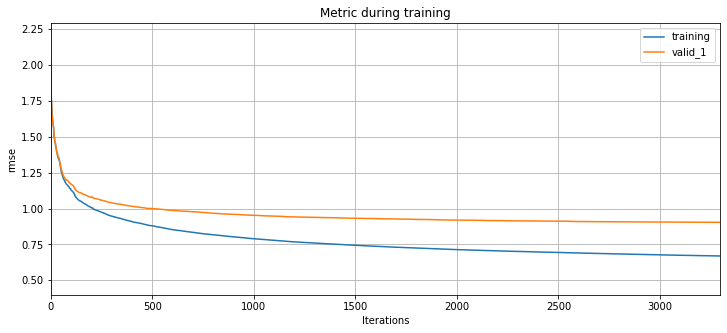

In [126]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

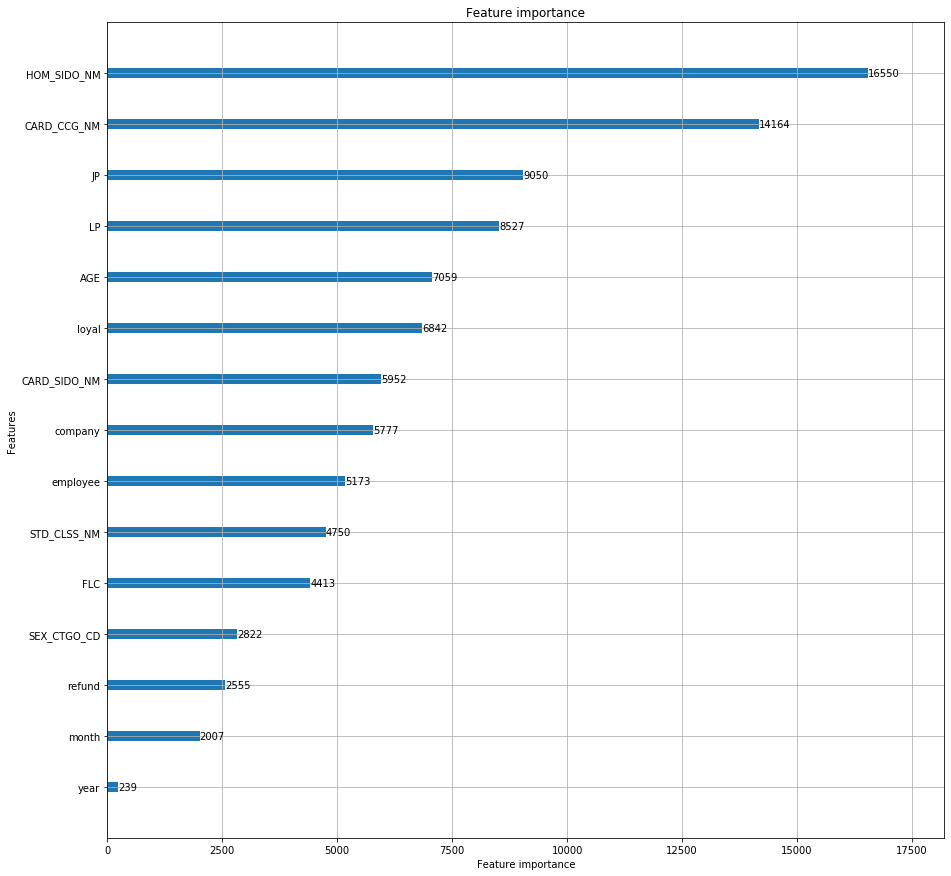

In [127]:
lgb.plot_importance(model, figsize=(15,15))

In [140]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [141]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [142]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.082119e+08
1,202004,강원,골프장 운영업,4.016383e+09
2,202004,강원,과실 및 채소 소매업,8.050447e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.642284e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [143]:
submission.to_csv('submission/submission 0730 only 2019.csv', encoding='utf-8-sig')

In [133]:
temp_a

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,2,1,2,263.0,399.0,0.107502,0.272875,90.0,4,-29.0,2019
1,0,4,0,0,2,2,2,263.0,399.0,0.107502,0.272875,90.0,4,-29.0,2019
2,0,4,0,0,3,1,3,263.0,399.0,0.107502,0.272875,90.0,4,-29.0,2019
3,0,4,0,0,3,1,4,263.0,399.0,0.107502,0.272875,90.0,4,-29.0,2019
4,0,4,0,0,3,2,3,263.0,399.0,0.107502,0.272875,90.0,4,-29.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355838,16,202,40,16,3,1,3,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2019
355839,16,202,40,16,4,1,4,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2019
355840,16,202,40,16,4,2,4,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2019
355841,16,202,40,16,5,1,5,11.0,492.0,0.021806,0.053595,739.0,4,999.0,2019


In [132]:
validation

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
4737058,0,4,0,0,2,1,2,263.0,399.0,0.079882,0.205675,76.0,2,-44.0,2020
4737059,0,4,0,0,3,1,3,263.0,399.0,0.079882,0.205675,76.0,2,-44.0,2020
4737060,0,4,0,0,3,2,3,263.0,399.0,0.079882,0.205675,76.0,2,-44.0,2020
4737061,0,4,0,0,4,1,4,263.0,399.0,0.079882,0.205675,76.0,2,-44.0,2020
4737062,0,4,0,0,4,2,4,263.0,399.0,0.079882,0.205675,76.0,2,-44.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5328205,16,202,40,16,2,1,2,11.0,492.0,0.004484,0.010694,746.0,3,999.0,2020
5328206,16,202,40,16,3,1,3,11.0,492.0,0.004484,0.010694,746.0,3,999.0,2020
5328207,16,202,40,16,4,1,4,11.0,492.0,0.004484,0.010694,746.0,3,999.0,2020
5328208,16,202,40,16,4,2,4,11.0,492.0,0.004484,0.010694,746.0,3,999.0,2020
